In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.kernel_ridge import KernelRidge
%matplotlib inline
pd.options.mode.chained_assignment = None

# Load the fatalities dataset and clean it

In [2]:
fatal_df = pd.read_excel(open('fatal.xlsx', 'rb'), sheet_name="Data")
fatal_df = fatal_df.drop(['AvyYear', 'Description', 'Location', 'Setting'], axis = 1)
fatal_df['YYYY'], fatal_df['MM'], fatal_df['DD'] = fatal_df['YYYY'].astype(int), fatal_df['MM'].astype(int), fatal_df['DD'].astype(int)
fatal_df['State'], fatal_df['PrimaryActivity'], fatal_df['TravelMode'] = fatal_df['State'].astype('category'), fatal_df['PrimaryActivity'].astype('category'), fatal_df['TravelMode'].astype('category')
fatal_df['Killed'] = fatal_df["Killed"].astype(int)
fatal_df = fatal_df.rename(columns = {'YYYY':'Year', 'MM':'Month', 'DD':'Day'})
fatal_df.dtypes

Year                  int64
Month                 int64
Day                   int64
State              category
PrimaryActivity    category
TravelMode         category
Killed                int64
dtype: object

In [3]:
fatal_df

,Year,Month,Day,State,PrimaryActivity,TravelMode,Killed
0,2021,5,13,AK,Climber,Foot,1
1,2021,3,27,AK,Motorized Guided client,Ski,1
2,2021,3,22,CO,Sidecountry Rider,Ski,1
3,2021,3,20,CA,Snowmobiler,Foot,1
4,2021,2,27,ID,Snowmobiler,Snowmobile,1
...,...,...,...,...,...,...,...
937,1952,1,19,ID,Inbounds Rider,Ski,4
938,1952,1,14,CA,Resident,Foot,2
939,1952,1,7,CO,Miner,NaN,1
940,1951,12,30,CO,Motorist,NaN,2


# Exploratory Data Analysis

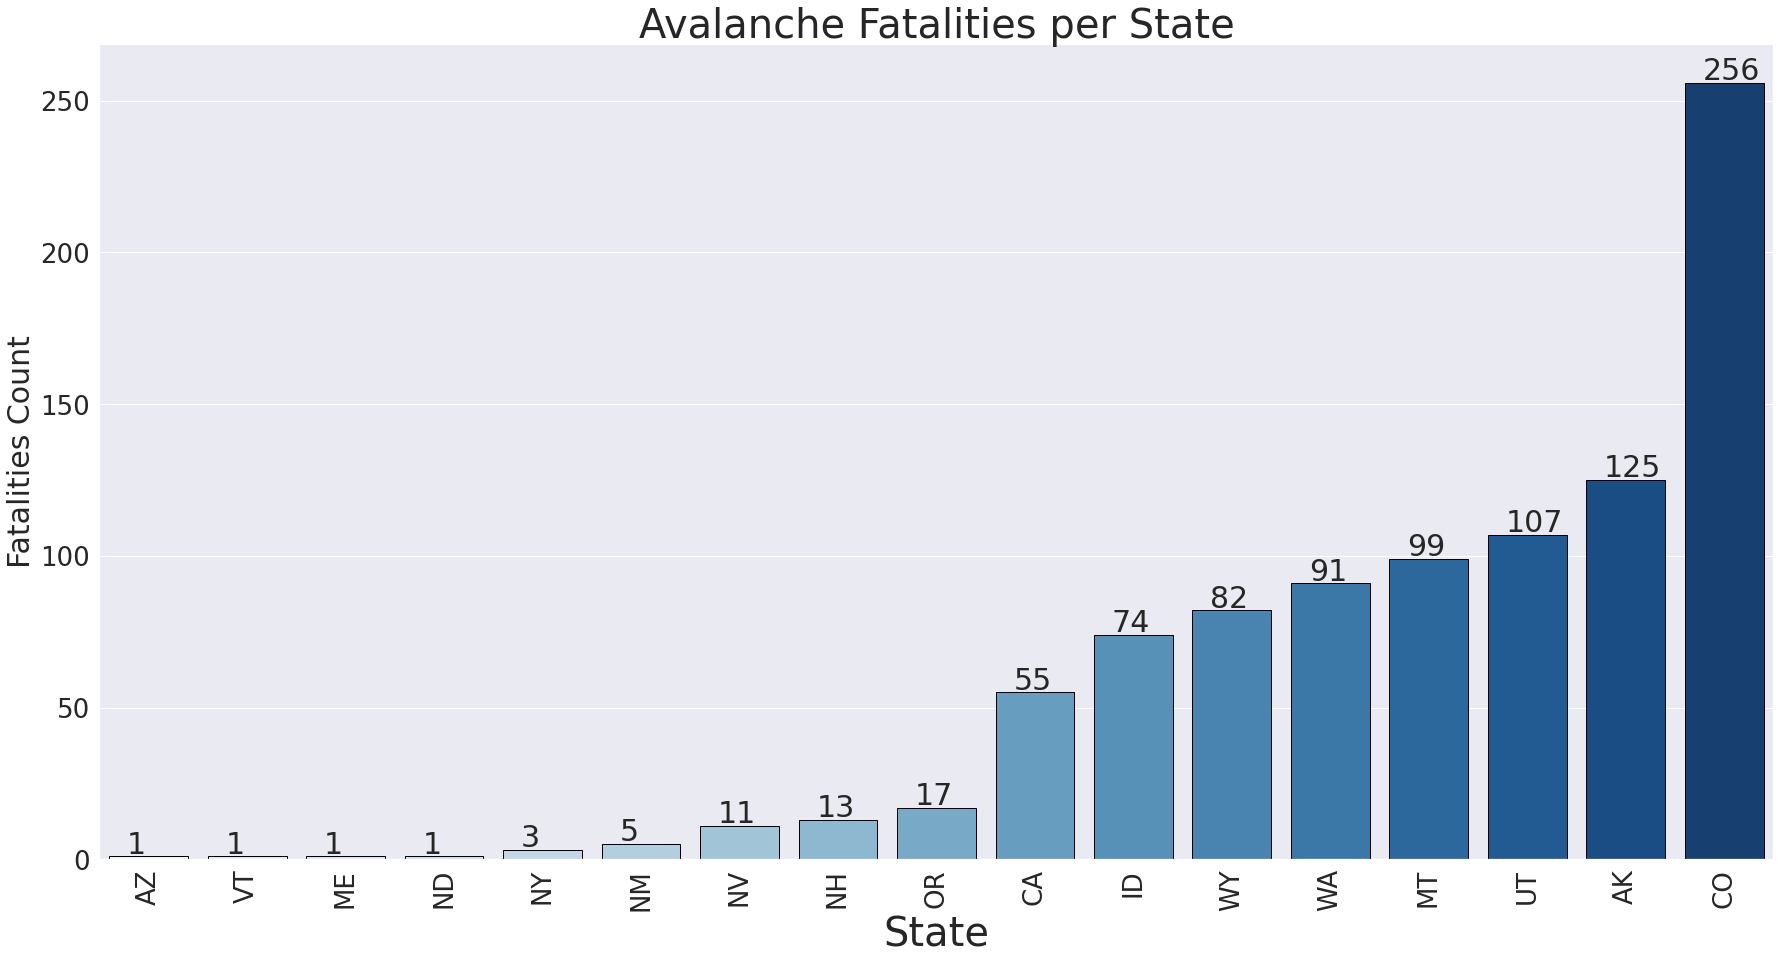

In [4]:
sns.set(rc={'figure.figsize':(30, 15)})
ax = sns.countplot(x='State', data = fatal_df, order = fatal_df['State'].value_counts(ascending=True).index, edgecolor = "Black", palette='Blues')
plt.xticks(rotation = 90, fontsize = 26)
plt.yticks(fontsize=26)
plt.xlabel("State", fontsize=40)
plt.ylabel("Fatalities Count", fontsize=30)
plt.title("Avalanche Fatalities per State", fontsize = 40)
for p in ax.patches:
   ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.18, p.get_height()+1), fontsize=30)
plt.show()

### Colorado is the deadliest state, which is no surprise for those familiar with avalanche sciences and the infamous Colorado snowpack. 

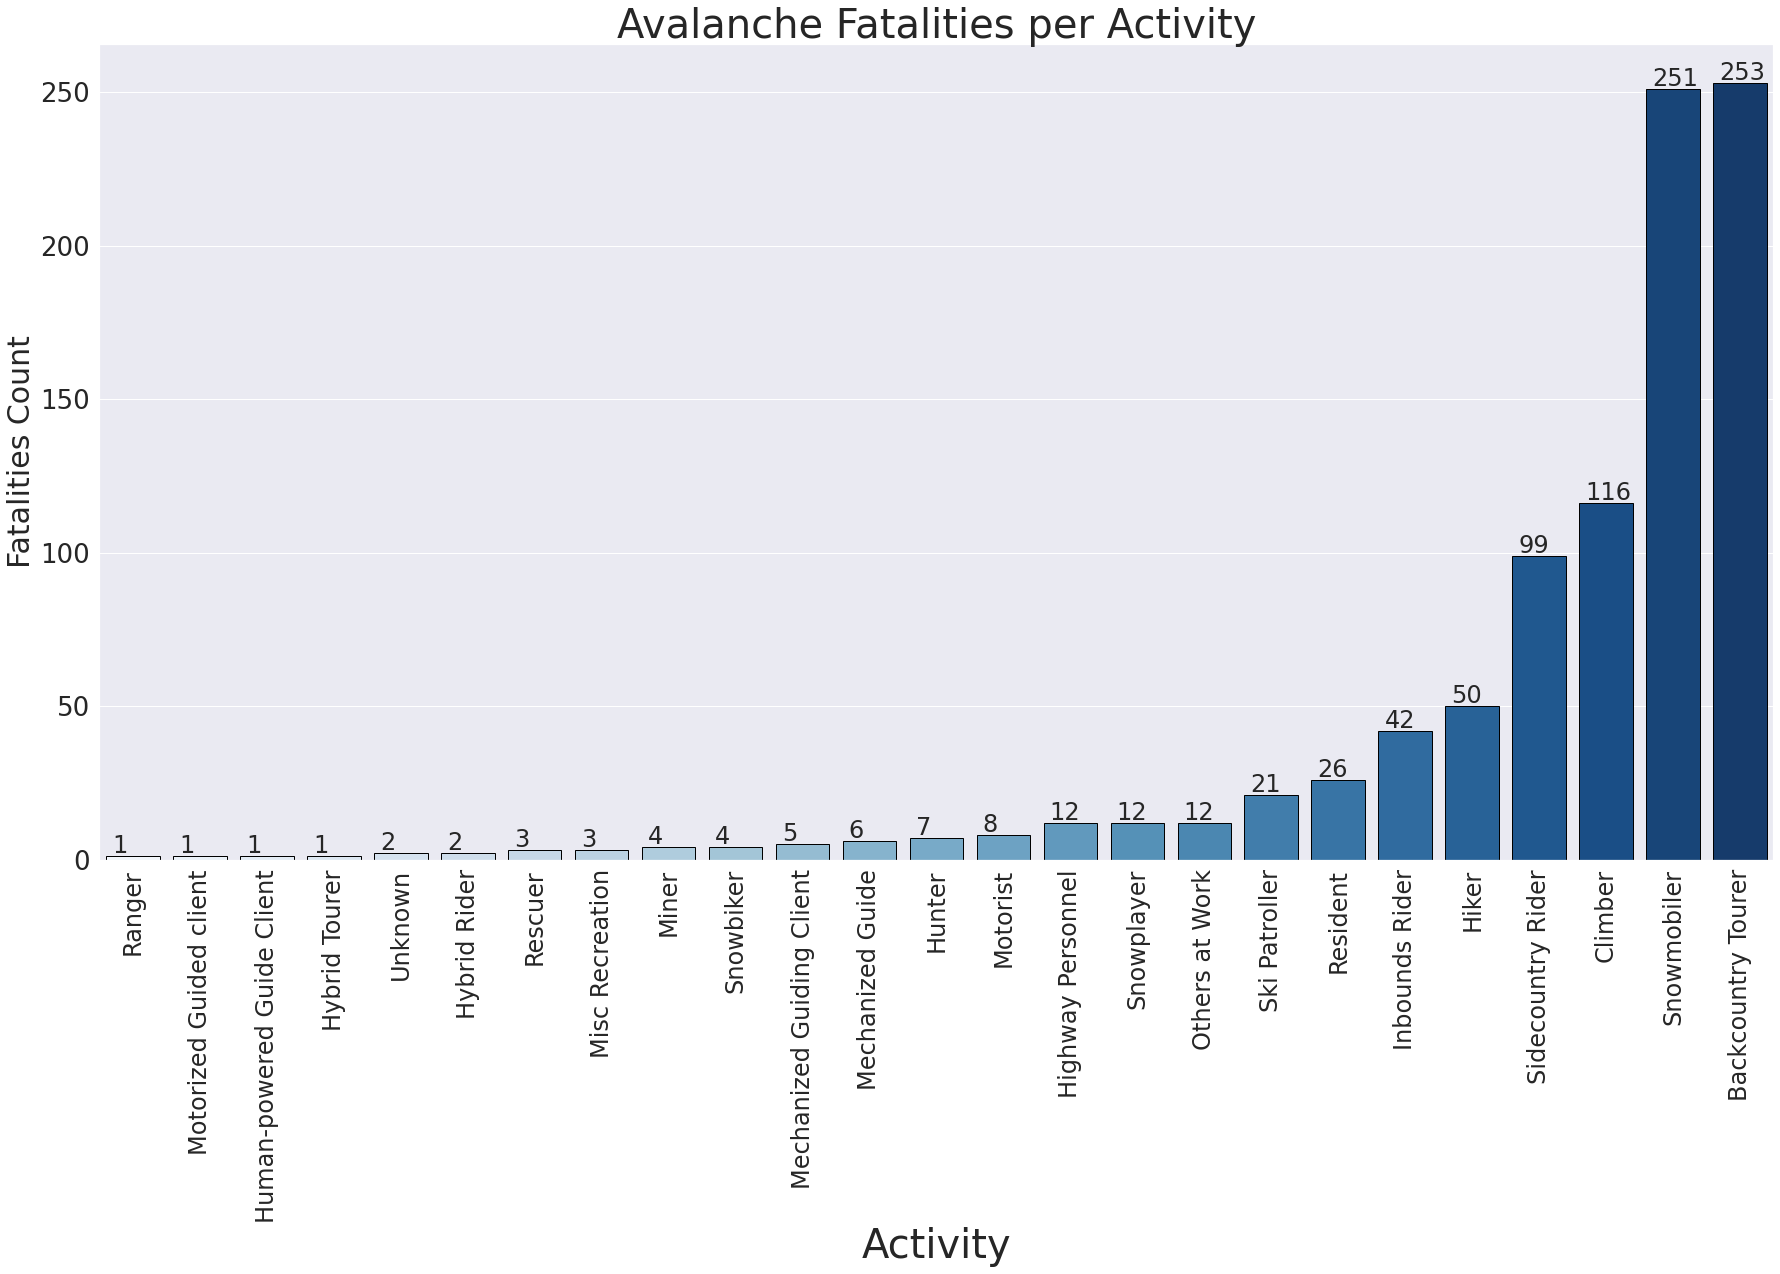

In [5]:
sns.set(rc={'figure.figsize':(30, 15)})
ax = sns.countplot(x='PrimaryActivity', data = fatal_df, order = fatal_df['PrimaryActivity'].value_counts(ascending=True).index, edgecolor = "Black", palette='Blues')
plt.xticks(rotation = 90, fontsize = 24)
plt.yticks(fontsize=26)
plt.xlabel("Activity", fontsize=40)
plt.ylabel("Fatalities Count", fontsize=30)
plt.title("Avalanche Fatalities per Activity", fontsize = 40)
for p in ax.patches:
   ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.09, p.get_height()+1), fontsize=24)
plt.show()

### Backcountry Touring and snowmobiling are the two most dangerous activites by far, which makes sense as those two activities involve the most risk taking in avalanche terrain. 

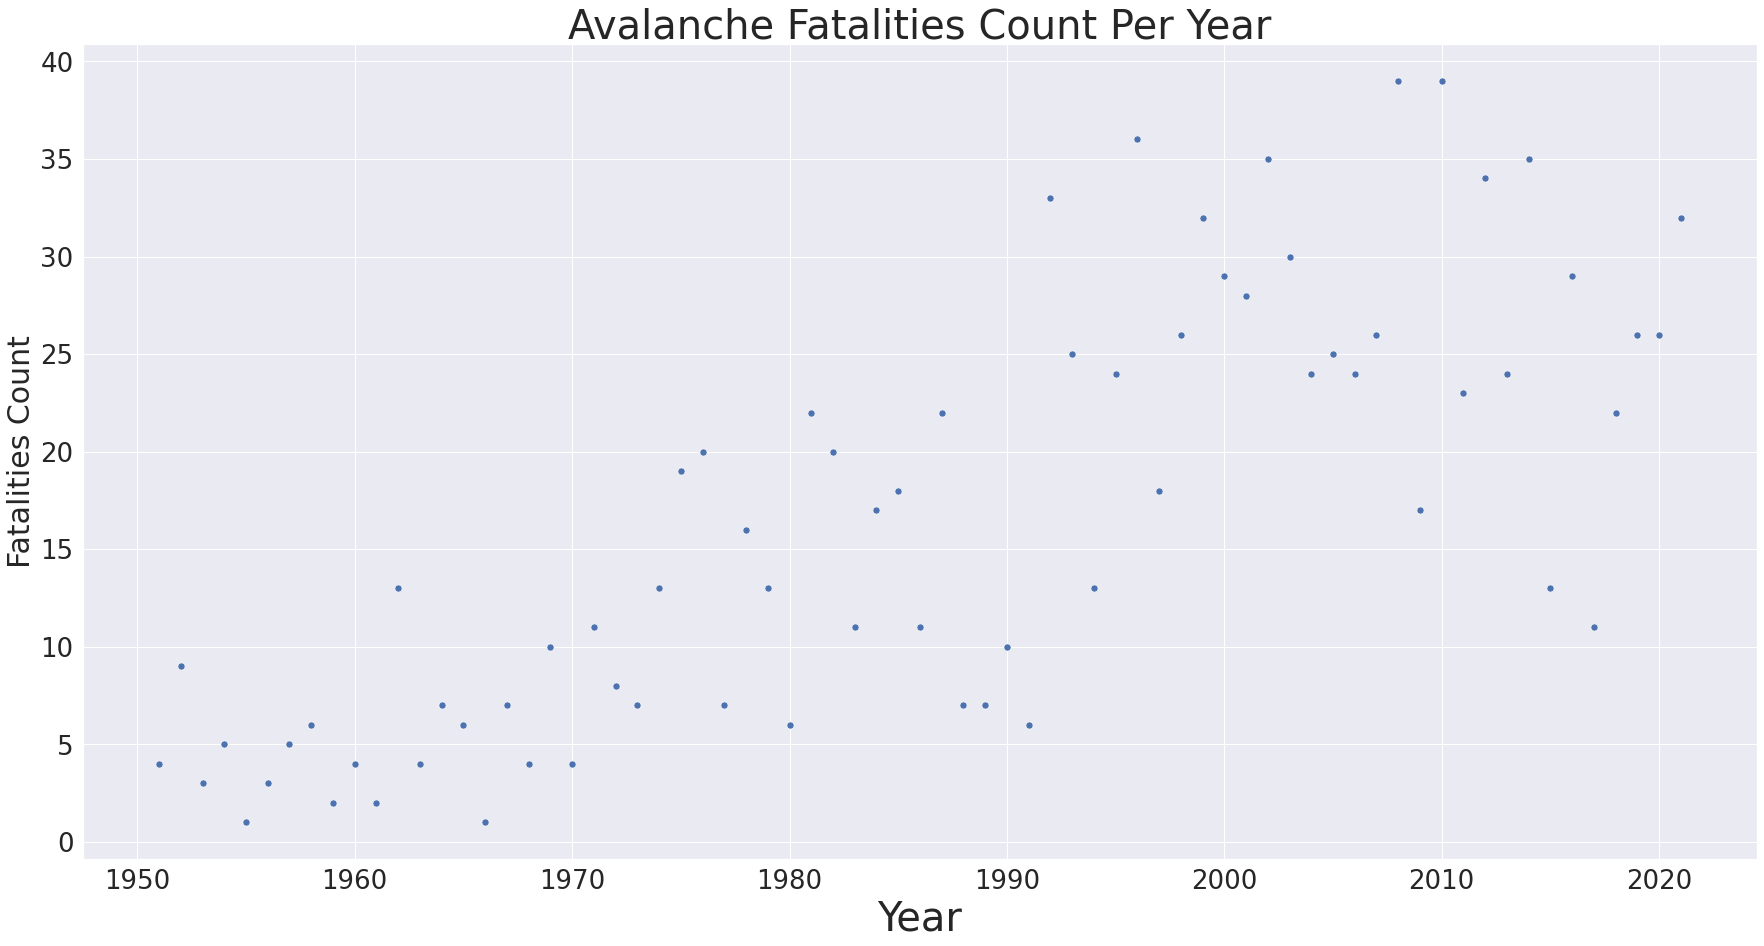

In [6]:
grouped_df = fatal_df.groupby(['Year']).sum()
grouped_df['Year'] = grouped_df.index
sns.set(rc={'figure.figsize':(30, 15)})
sns.scatterplot(x = grouped_df["Year"], y = grouped_df['Killed'], s=50)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
plt.xlabel("Year", fontsize=40)
plt.ylabel("Fatalities Count", fontsize=30)
plt.title("Avalanche Fatalities Count Per Year", fontsize = 40)
plt.show()

### Here we see a relatively clear positive linear relationship in the amount of avalanche fatalities over time, so we will try some regression methods to see if future avalanche counts can be accurately predicted. 

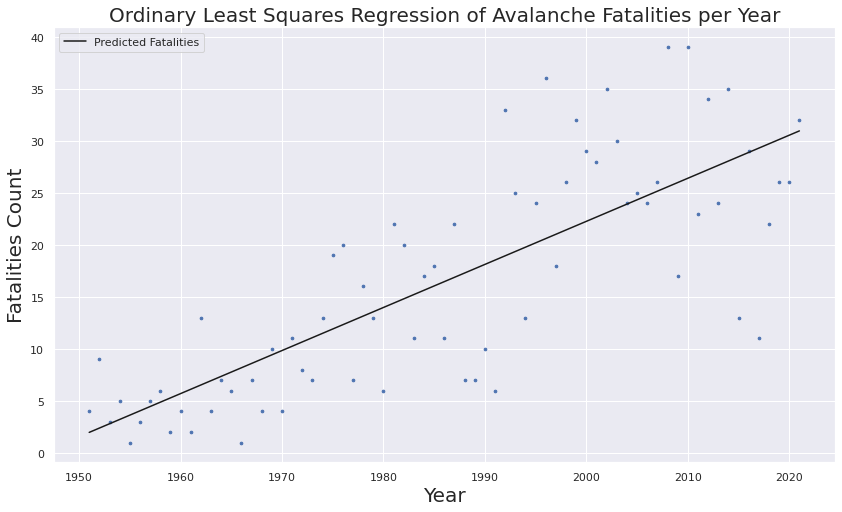

The R squared value of the OLS Regression is: 0.6119298535984596
The Root Mean Squared Error of the OLS Regression is: 6.756354008963072


In [7]:
y = np.array(grouped_df['Killed']).reshape(-1, 1)
X = np.array(grouped_df['Year']).reshape(-1,1)
lin_mod = linear_model.LinearRegression().fit(X, y)

y_pred = lin_mod.predict(X)
plt.figure(figsize = (14, 8))
plt.scatter(X, y, s = 7)
plt.plot(X, y_pred, color = 'k', label = "Predicted Fatalities")
plt.legend()
plt.title("Ordinary Least Squares Regression of Avalanche Fatalities per Year", fontsize = 20)
plt.xlabel("Year", fontsize = 20)
plt.ylabel("Fatalities Count", fontsize = 20)
plt.show()

print("The R squared value of the OLS Regression is:", r2_score(y_true = y, y_pred = y_pred))
print("The Root Mean Squared Error of the OLS Regression is:", mean_squared_error(y_true = y, y_pred = y_pred, squared = False))

### OLS Regression used to set a baseline, then we will try kernel smoothing methods to see if the regression can be improved. 

In [8]:
y = np.array(grouped_df['Killed']).reshape(-1, 1)
X = np.array(grouped_df['Year']).reshape(-1,1)

krr1 = KernelRidge(degree = 2, kernel='linear')
krr1.fit(X, y)
pred1 = krr1.predict(X)
print("Kernel Ridge with linear results in RMSE of ", np.sqrt(mean_squared_error(pred1, y)))

krr2 = KernelRidge(degree = 2, kernel='rbf')
krr2.fit(X, y)
pred2 = krr2.predict(X)
print("Kernel Ridge with rbf results in RMSE of ", np.sqrt(mean_squared_error(pred2, y)))

krr3 = KernelRidge(degree = 2, kernel='polynomial')
krr3.fit(X, y)
pred3 = krr3.predict(X)
print("Kernel Ridge with polynomial results in RMSE of ", np.sqrt(mean_squared_error(pred3, y)))

krr4 = KernelRidge(degree = 2, kernel='laplacian')
krr4.fit(X, y)
pred4 = krr4.predict(X)
print("Kernel Ridge with laplacian results in RMSE of ", np.sqrt(mean_squared_error(pred4, y)))

krr5 = KernelRidge(degree = 2, kernel='cosine')
krr5.fit(X, y)
pred5 = krr5.predict(X)
print("Kernel Ridge with cosine results in RMSE of ", np.sqrt(mean_squared_error(pred5, y)))

Kernel Ridge with linear results in RMSE of  10.712963247897063
Kernel Ridge with rbf results in RMSE of  7.744247074255138
Kernel Ridge with polynomial results in RMSE of  6.7673035275914035
Kernel Ridge with laplacian results in RMSE of  6.992941994973213
Kernel Ridge with cosine results in RMSE of  10.848102843873221


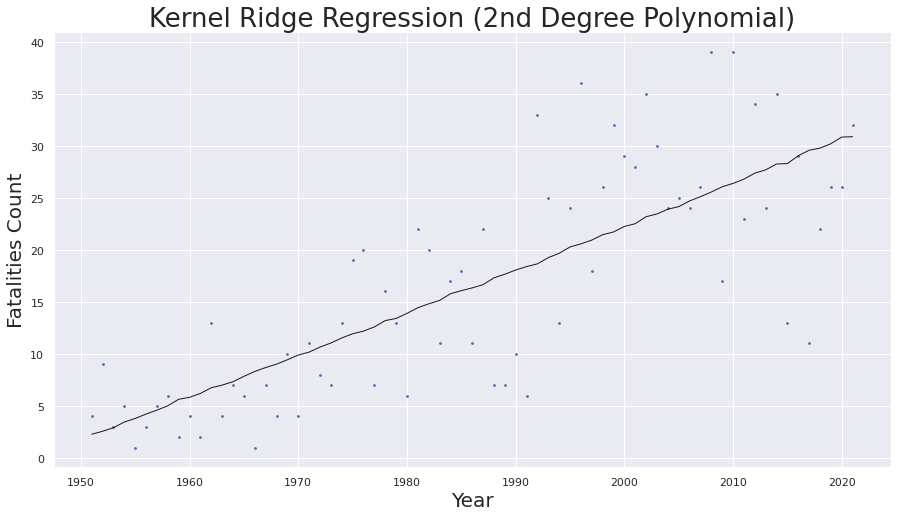

Kernel Ridge with polynomial degree 2 results in RMSE of  6.7673035275914035


In [9]:
plt.figure(figsize=(15, 8))
plt.scatter(X, y, 3, color='C0')
plt.plot(X, pred3, linewidth=1, color='k')
plt.title("Kernel Ridge Regression (2nd Degree Polynomial)", fontsize=26)
plt.ylabel("Fatalities Count", fontsize = 20)
plt.xlabel("Year", fontsize=20)
plt.show()
print("Kernel Ridge with polynomial degree 2 results in RMSE of ", np.sqrt(mean_squared_error(pred3, y)))

### Despite testing a variety of kernel smoothing regressions, we see no improvement in RMSE over basic OLS regression.